### GTSRB Traffic Sign Recognition - Part III

### CODE ONLY, For a detailed report, please refer to the GTSRB Final Report Part III

#### by Sean Sungil Kim

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# importing necessary modules
import numpy as np
import seaborn as sns
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import time
import warnings
warnings.filterwarnings("ignore")

# custom python scripts
import GTSRB_sungil           # preprocessing

Using TensorFlow backend.


### Preprocessing

In [3]:
# reading the GTSRB data utilizing the custom python script
# grayscaled
num_classes = 43
data_GTSRB, data_class, labels = GTSRB_sungil.load_data(num_classes)
gray_GTSRB = GTSRB_sungil.gray_convrt(data_GTSRB)

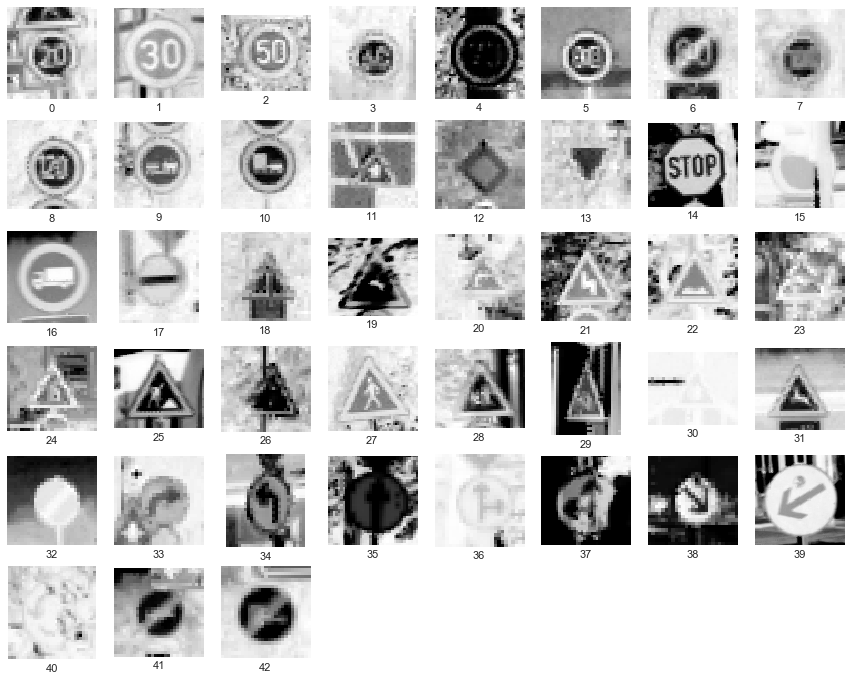

In [4]:
# one image example from each class, pre grayscale and downsizing
plt.figure(figsize = (15, 12))
for i in range(num_classes):
    plt.subplot(6, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(gray_GTSRB[data_class.tolist().index([i])], cmap = plt.cm.binary)
    plt.xlabel(i)
plt.show()

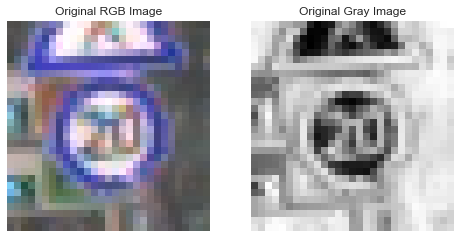

In [5]:
# original and post grayscale comparison 
plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(data_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original RGB Image')
plt.subplot(1, 2, 2)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(gray_GTSRB[0], cmap = plt.cm.binary)
plt.title('Original Gray Image')
plt.show()

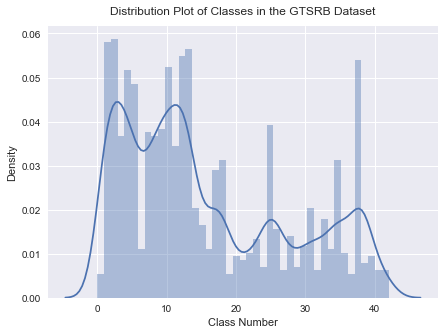

Total 39209 images in the GTSRB dataset
Total 39209 classes in the GTSRB class


In [6]:
# original class distribution
fig = plt.figure(figsize = (7, 5))
sns.distplot(data_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the GTSRB Dataset', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

# length of the data
print('Total %i images in the GTSRB dataset' % len(data_GTSRB))
print('Total %i classes in the GTSRB class' % len(data_class))

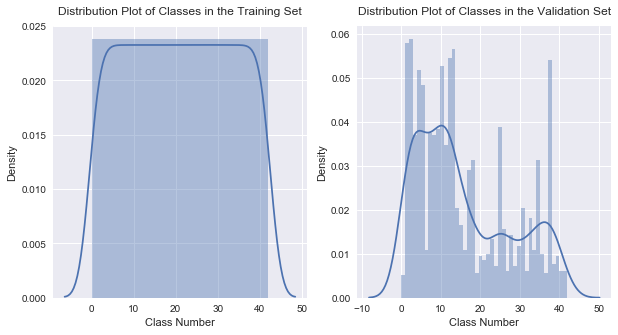

Total of 8514 images in the training data
Total of 2157 images in the validation data
79.79 percent training set, 20.21 percent validation set


In [7]:
# resizing
resize_data = GTSRB_sungil.resize_all(gray_GTSRB, size = (28, 28))

# normalizing data, RGB/grayscale images are out of 255
norm_resized = resize_data / 255.0

# reshaping to be suitable for keras and tensorflow
nn_reshaped = GTSRB_sungil.nn_reshape(norm_resized)

# 80% train 20% test split
# test_size was set to 0.055, to maintain the validation set size to 20% post under-sampling
x_train, x_val, y_class, y_val = train_test_split(nn_reshaped, data_class,\
                                                  stratify = data_class, test_size = 0.055)

# random under-sampling
und_train, und_class = GTSRB_sungil.under_sample(x_train, y_class)

# converting a class vector to binary class matrix
y_class_bin = keras.utils.to_categorical(und_class, num_classes)
y_val_bin = keras.utils.to_categorical(y_val, num_classes)

# post split class distribution
fig = plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.distplot(und_class, bins = num_classes)
plt.title('Distribution Plot of Classes in the Training Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.subplot(1, 2, 2)
sns.distplot(y_val, bins = num_classes)
plt.title('Distribution Plot of Classes in the Validation Set', y = 1.02)
plt.xlabel('Class Number')
plt.ylabel('Density')
plt.show()

tot_len = len(und_train) + len(x_val)
print('Total of %i images in the training data' % len(und_train))
print('Total of %i images in the validation data' % len(x_val))
print('%0.2f percent training set, %0.2f percent validation set' \
      % (len(und_train)/tot_len*100, len(x_val)/tot_len*100))

### Exploring with ConvNet Architectures

#### Small (Conv-Pool-Dropout)

In [8]:
model1 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history1 = model1.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 48s 6ms/step - loss: 2.8053 - acc: 0.2859 - val_loss: 1.6731 - val_acc: 0.5994
Epoch 2/20
8514/8514 [==============================] - 49s 6ms/step - loss: 1.2482 - acc: 0.6717 - val_loss: 0.9421 - val_acc: 0.7580
Epoch 3/20
8514/8514 [==============================] - 52s 6ms/step - loss: 0.7620 - acc: 0.7981 - val_loss: 0.6625 - val_acc: 0.8414
Epoch 4/20
8514/8514 [==============================] - 51s 6ms/step - loss: 0.5538 - acc: 0.8537 - val_loss: 0.5248 - val_acc: 0.8688
Epoch 5/20
8514/8514 [==============================] - 51s 6ms/step - loss: 0.4215 - acc: 0.8861 - val_loss: 0.4760 - val_acc: 0.8702
Epoch 6/20
8514/8514 [==============================] - 54s 6ms/step - loss: 0.3465 - acc: 0.9045 - val_loss: 0.3993 - val_acc: 0.9022
Epoch 7/20
8514/8514 [==============================] - 48s 6ms/step - loss: 0.2870 - acc: 0.9220 - val_loss: 0.3662 - val_acc: 0.9050
Epoch 8

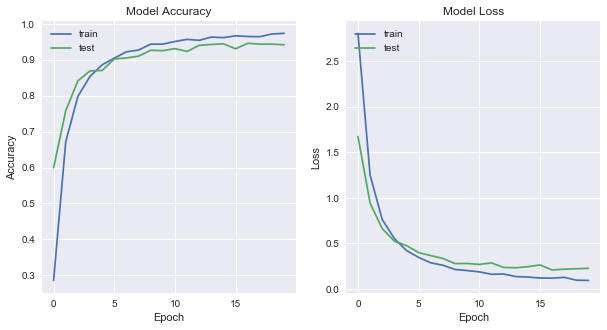

In [9]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['acc']), plt.plot(history1.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss']), plt.plot(history1.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [10]:
model2 = keras.Sequential([\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history2 = model2.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 108s 13ms/step - loss: 2.5318 - acc: 0.3565 - val_loss: 1.3490 - val_acc: 0.6630
Epoch 2/20
8514/8514 [==============================] - 101s 12ms/step - loss: 0.9988 - acc: 0.7274 - val_loss: 0.8075 - val_acc: 0.7988
Epoch 3/20
8514/8514 [==============================] - 93s 11ms/step - loss: 0.6075 - acc: 0.8370 - val_loss: 0.5617 - val_acc: 0.8605
Epoch 4/20
8514/8514 [==============================] - 96s 11ms/step - loss: 0.4443 - acc: 0.8810 - val_loss: 0.4341 - val_acc: 0.8962
Epoch 5/20
8514/8514 [==============================] - 93s 11ms/step - loss: 0.3512 - acc: 0.9050 - val_loss: 0.3752 - val_acc: 0.9101
Epoch 6/20
8514/8514 [==============================] - 98s 11ms/step - loss: 0.2767 - acc: 0.9273 - val_loss: 0.3868 - val_acc: 0.8948
Epoch 7/20
8514/8514 [==============================] - 90s 11ms/step - loss: 0.2368 - acc: 0.9358 - val_loss: 0.3283 - val_acc: 0.912

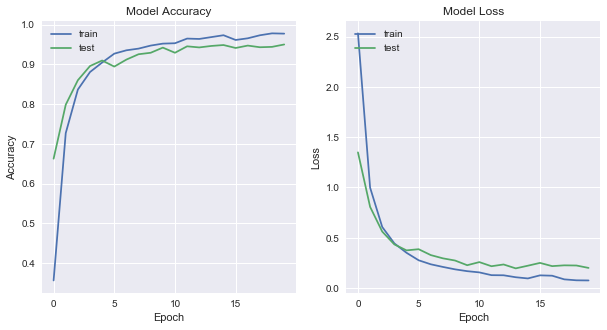

In [11]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['acc']), plt.plot(history2.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss']), plt.plot(history2.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Conv-Pool-Dropout)

In [12]:
model3 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history3 = model3.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 77s 9ms/step - loss: 2.1547 - acc: 0.4463 - val_loss: 0.8727 - val_acc: 0.7682
Epoch 2/20
8514/8514 [==============================] - 76s 9ms/step - loss: 0.6682 - acc: 0.8074 - val_loss: 0.5180 - val_acc: 0.8744
Epoch 3/20
8514/8514 [==============================] - 83s 10ms/step - loss: 0.3812 - acc: 0.8898 - val_loss: 0.3399 - val_acc: 0.9124
Epoch 4/20
8514/8514 [==============================] - 81s 9ms/step - loss: 0.2676 - acc: 0.9237 - val_loss: 0.2571 - val_acc: 0.9360
Epoch 5/20
8514/8514 [==============================] - 75s 9ms/step - loss: 0.2131 - acc: 0.9361 - val_loss: 0.2135 - val_acc: 0.9448
Epoch 6/20
8514/8514 [==============================] - 81s 10ms/step - loss: 0.1576 - acc: 0.9553 - val_loss: 0.1891 - val_acc: 0.9560
Epoch 7/20
8514/8514 [==============================] - 80s 9ms/step - loss: 0.1442 - acc: 0.9581 - val_loss: 0.1666 - val_acc: 0.9597
Epoch

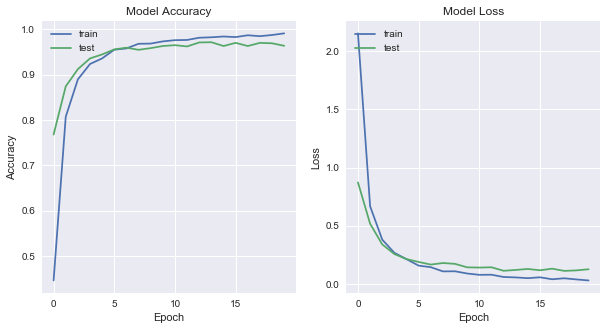

In [13]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history3.history['acc']), plt.plot(history3.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss']), plt.plot(history3.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [14]:
model4 = keras.Sequential([\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history4 = model4.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 108s 13ms/step - loss: 2.2811 - acc: 0.4092 - val_loss: 0.9710 - val_acc: 0.7121
Epoch 2/20
8514/8514 [==============================] - 108s 13ms/step - loss: 0.7291 - acc: 0.7838 - val_loss: 0.5530 - val_acc: 0.8674
Epoch 3/20
8514/8514 [==============================] - 107s 13ms/step - loss: 0.4529 - acc: 0.8743 - val_loss: 0.3853 - val_acc: 0.8957
Epoch 4/20
8514/8514 [==============================] - 110s 13ms/step - loss: 0.3172 - acc: 0.9070 - val_loss: 0.3247 - val_acc: 0.9166
Epoch 5/20
8514/8514 [==============================] - 107s 13ms/step - loss: 0.2603 - acc: 0.9247 - val_loss: 0.2409 - val_acc: 0.9360
Epoch 6/20
8514/8514 [==============================] - 109s 13ms/step - loss: 0.1949 - acc: 0.9407 - val_loss: 0.2003 - val_acc: 0.9467
Epoch 7/20
8514/8514 [==============================] - 108s 13ms/step - loss: 0.1810 - acc: 0.9468 - val_loss: 0.1896 - val_acc: 

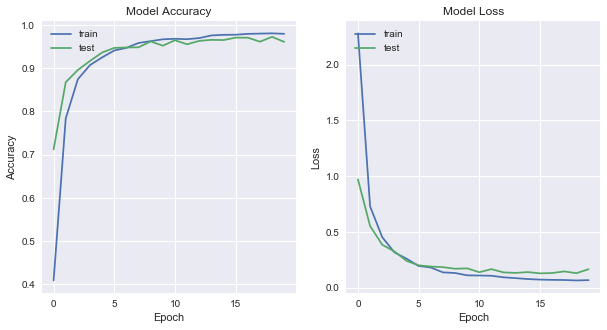

In [15]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history4.history['acc']), plt.plot(history4.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss']), plt.plot(history4.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [16]:
model5 = keras.Sequential([\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model5.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history5 = model5.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 163s 19ms/step - loss: 2.2439 - acc: 0.4206 - val_loss: 0.8589 - val_acc: 0.7798
Epoch 2/20
8514/8514 [==============================] - 163s 19ms/step - loss: 0.6912 - acc: 0.8046 - val_loss: 0.4396 - val_acc: 0.8855
Epoch 3/20
8514/8514 [==============================] - 165s 19ms/step - loss: 0.4036 - acc: 0.8856 - val_loss: 0.3085 - val_acc: 0.9226
Epoch 4/20
8514/8514 [==============================] - 165s 19ms/step - loss: 0.2851 - acc: 0.9207 - val_loss: 0.2962 - val_acc: 0.9235
Epoch 5/20
8514/8514 [==============================] - 164s 19ms/step - loss: 0.2358 - acc: 0.9352 - val_loss: 0.2403 - val_acc: 0.9342
Epoch 6/20
8514/8514 [==============================] - 162s 19ms/step - loss: 0.1777 - acc: 0.9476 - val_loss: 0.2422 - val_acc: 0.9397
Epoch 7/20
8514/8514 [==============================] - 169s 20ms/step - loss: 0.1658 - acc: 0.9527 - val_loss: 0.1717 - val_acc: 

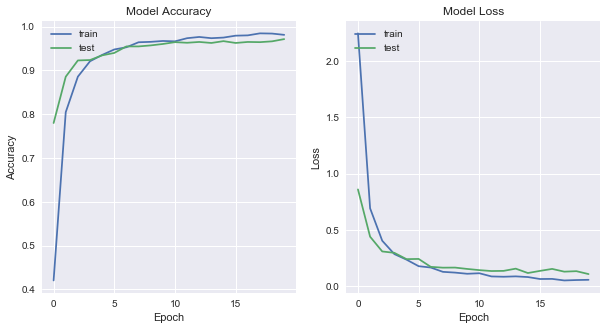

In [17]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history5.history['acc']), plt.plot(history5.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss']), plt.plot(history5.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium (Conv-Pool-Conv-Pool-Dropout)

In [18]:
model6 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Dropout(0.25), keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model6.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history6 = model6.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 23s 3ms/step - loss: 2.9047 - acc: 0.2411 - val_loss: 1.5653 - val_acc: 0.5716
Epoch 2/20
8514/8514 [==============================] - 25s 3ms/step - loss: 1.2411 - acc: 0.6382 - val_loss: 0.8402 - val_acc: 0.7738
Epoch 3/20
8514/8514 [==============================] - 25s 3ms/step - loss: 0.7556 - acc: 0.7798 - val_loss: 0.6122 - val_acc: 0.8326
Epoch 4/20
8514/8514 [==============================] - 22s 3ms/step - loss: 0.5653 - acc: 0.8379 - val_loss: 0.4575 - val_acc: 0.8850
Epoch 5/20
8514/8514 [==============================] - 28s 3ms/step - loss: 0.4465 - acc: 0.8668 - val_loss: 0.3999 - val_acc: 0.8883
Epoch 6/20
8514/8514 [==============================] - 22s 3ms/step - loss: 0.3577 - acc: 0.8894 - val_loss: 0.3440 - val_acc: 0.9133
Epoch 7/20
8514/8514 [==============================] - 23s 3ms/step - loss: 0.3126 - acc: 0.9071 - val_loss: 0.2929 - val_acc: 0.9281
Epoch 8

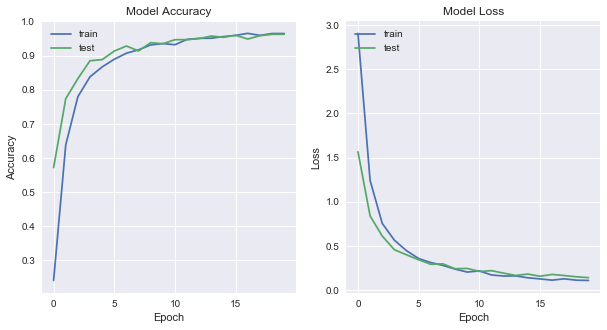

In [19]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['acc']), plt.plot(history6.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss']), plt.plot(history6.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [20]:
model7 = keras.Sequential([\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model7.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history7 = model7.fit(und_train, y_class_bin, epochs = 20, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/20
8514/8514 [==============================] - 47s 6ms/step - loss: 2.8807 - acc: 0.2411 - val_loss: 1.5498 - val_acc: 0.5772
Epoch 2/20
8514/8514 [==============================] - 53s 6ms/step - loss: 1.2100 - acc: 0.6467 - val_loss: 0.9069 - val_acc: 0.7432
Epoch 3/20
8514/8514 [==============================] - 47s 6ms/step - loss: 0.7641 - acc: 0.7754 - val_loss: 0.6246 - val_acc: 0.8155
Epoch 4/20
8514/8514 [==============================] - 46s 5ms/step - loss: 0.5594 - acc: 0.8300 - val_loss: 0.4534 - val_acc: 0.8600
Epoch 5/20
8514/8514 [==============================] - 52s 6ms/step - loss: 0.4383 - acc: 0.8694 - val_loss: 0.3753 - val_acc: 0.8966
Epoch 6/20
8514/8514 [==============================] - 53s 6ms/step - loss: 0.3408 - acc: 0.8978 - val_loss: 0.2915 - val_acc: 0.9212
Epoch 7/20
8514/8514 [==============================] - 53s 6ms/step - loss: 0.3076 - acc: 0.9071 - val_loss: 0.3044 - val_acc: 0.9147
Epoch 8

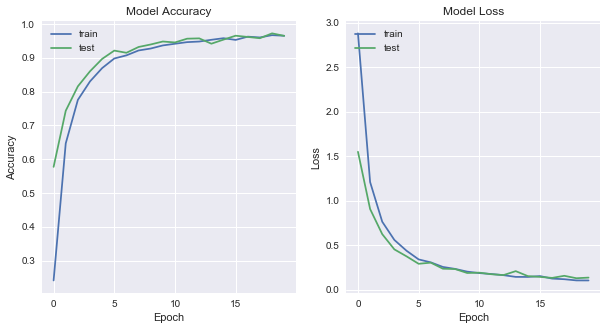

In [21]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history7.history['acc']), plt.plot(history7.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history7.history['loss']), plt.plot(history7.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

Since model6 and model7 demonstrated minimal signs of overfitting, deeper epochs are examined.

In [22]:
# model fitting
start_ts = time.time()
history6 = model6.fit(und_train, y_class_bin, epochs = 40, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/40
8514/8514 [==============================] - 24s 3ms/step - loss: 0.0987 - acc: 0.9696 - val_loss: 0.1386 - val_acc: 0.9652
Epoch 2/40
8514/8514 [==============================] - 25s 3ms/step - loss: 0.1044 - acc: 0.9677 - val_loss: 0.1443 - val_acc: 0.9648
Epoch 3/40
8514/8514 [==============================] - 26s 3ms/step - loss: 0.0897 - acc: 0.9696 - val_loss: 0.1234 - val_acc: 0.9699
Epoch 4/40
8514/8514 [==============================] - 29s 3ms/step - loss: 0.0941 - acc: 0.9703 - val_loss: 0.1224 - val_acc: 0.9680
Epoch 5/40
8514/8514 [==============================] - 27s 3ms/step - loss: 0.0899 - acc: 0.9718 - val_loss: 0.1274 - val_acc: 0.9671
Epoch 6/40
8514/8514 [==============================] - 25s 3ms/step - loss: 0.0749 - acc: 0.9760 - val_loss: 0.1458 - val_acc: 0.9648
Epoch 7/40
8514/8514 [==============================] - 30s 4ms/step - loss: 0.0780 - acc: 0.9745 - val_loss: 0.1614 - val_acc: 0.9546
Epoch 8

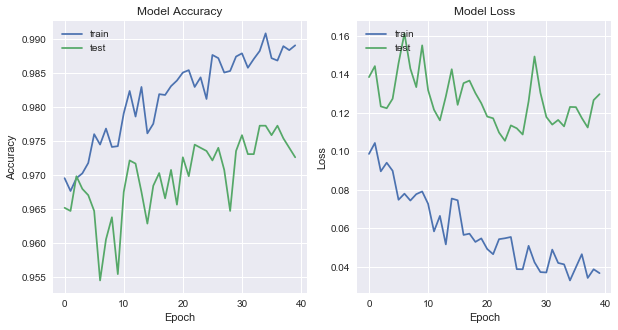

In [23]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history6.history['acc']), plt.plot(history6.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss']), plt.plot(history6.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [24]:
# model fitting
start_ts = time.time()
history7 = model7.fit(und_train, y_class_bin, epochs = 40, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/40
8514/8514 [==============================] - 47s 6ms/step - loss: 0.0974 - acc: 0.9688 - val_loss: 0.1333 - val_acc: 0.9666
Epoch 2/40
8514/8514 [==============================] - 46s 5ms/step - loss: 0.0937 - acc: 0.9724 - val_loss: 0.1248 - val_acc: 0.9671
Epoch 3/40
8514/8514 [==============================] - 52s 6ms/step - loss: 0.0979 - acc: 0.9688 - val_loss: 0.1167 - val_acc: 0.9662
Epoch 4/40
8514/8514 [==============================] - 58s 7ms/step - loss: 0.0860 - acc: 0.9728 - val_loss: 0.1224 - val_acc: 0.9648
Epoch 5/40
8514/8514 [==============================] - 48s 6ms/step - loss: 0.0768 - acc: 0.9774 - val_loss: 0.1112 - val_acc: 0.9662
Epoch 6/40
8514/8514 [==============================] - 51s 6ms/step - loss: 0.0802 - acc: 0.9736 - val_loss: 0.1318 - val_acc: 0.9620
Epoch 7/40
8514/8514 [==============================] - 54s 6ms/step - loss: 0.0845 - acc: 0.9743 - val_loss: 0.1377 - val_acc: 0.9657
Epoch 8

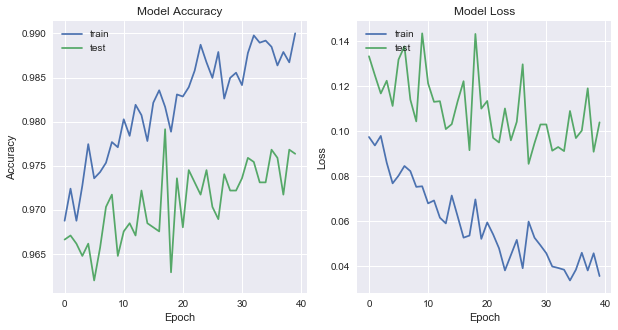

In [25]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history7.history['acc']), plt.plot(history7.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history7.history['loss']), plt.plot(history7.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

#### Medium-Large (Conv-Pool-Conv-Pool-Conv-Pool-Dropout)

In [28]:
model8 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model8.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history8 = model8.fit(und_train, y_class_bin, epochs = 40, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/40
8514/8514 [==============================] - 25s 3ms/step - loss: 3.6393 - acc: 0.0490 - val_loss: 3.2272 - val_acc: 0.0978
Epoch 2/40
8514/8514 [==============================] - 17s 2ms/step - loss: 2.7116 - acc: 0.2239 - val_loss: 2.1720 - val_acc: 0.3551
Epoch 3/40
8514/8514 [==============================] - 17s 2ms/step - loss: 2.0361 - acc: 0.3898 - val_loss: 1.6379 - val_acc: 0.4998
Epoch 4/40
8514/8514 [==============================] - 19s 2ms/step - loss: 1.6705 - acc: 0.4863 - val_loss: 1.2429 - val_acc: 0.6324
Epoch 5/40
8514/8514 [==============================] - 21s 2ms/step - loss: 1.4262 - acc: 0.5587 - val_loss: 1.0278 - val_acc: 0.7163
Epoch 6/40
8514/8514 [==============================] - 17s 2ms/step - loss: 1.2521 - acc: 0.6055 - val_loss: 0.9080 - val_acc: 0.7362
Epoch 7/40
8514/8514 [==============================] - 22s 3ms/step - loss: 1.1281 - acc: 0.6474 - val_loss: 0.7981 - val_acc: 0.7682
Epoch 8

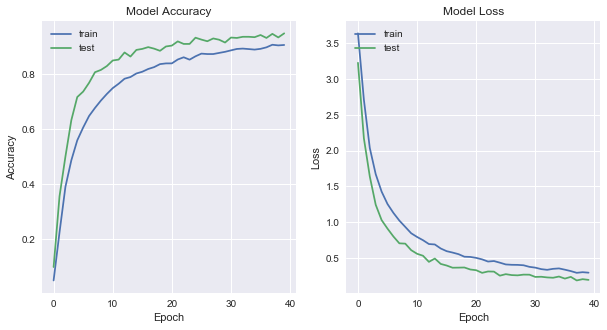

In [29]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history8.history['acc']), plt.plot(history8.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history8.history['loss']), plt.plot(history8.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [31]:
model9 = keras.Sequential([\
    keras.layers.Conv2D(32, (3, 3), strides = (1, 1), activation = tf.nn.relu,\
                        input_shape = und_train.shape[1:4]),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)),\
    keras.layers.Conv2D(64, (3, 3), strides = (1, 1), activation = tf.nn.relu),\
    keras.layers.MaxPooling2D(pool_size = (2, 2)), keras.layers.Dropout(0.25),\
    keras.layers.Flatten(), keras.layers.Dense(512, activation = tf.nn.relu),\
    keras.layers.Dropout(0.5), keras.layers.Dense(num_classes, activation = tf.nn.softmax)])
model9.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# model fitting
start_ts = time.time()
history9 = model9.fit(und_train, y_class_bin, epochs = 40, validation_data = (x_val, y_val_bin))
print("Total Runtime:", time.time()-start_ts)

Train on 8514 samples, validate on 2157 samples
Epoch 1/40
8514/8514 [==============================] - 25s 3ms/step - loss: 3.5763 - acc: 0.0614 - val_loss: 2.9052 - val_acc: 0.1525
Epoch 2/40
8514/8514 [==============================] - 25s 3ms/step - loss: 2.2854 - acc: 0.3206 - val_loss: 1.5248 - val_acc: 0.5234
Epoch 3/40
8514/8514 [==============================] - 24s 3ms/step - loss: 1.4668 - acc: 0.5444 - val_loss: 1.0140 - val_acc: 0.7024
Epoch 4/40
8514/8514 [==============================] - 26s 3ms/step - loss: 1.0550 - acc: 0.6745 - val_loss: 0.6942 - val_acc: 0.8183
Epoch 5/40
8514/8514 [==============================] - 27s 3ms/step - loss: 0.8053 - acc: 0.7459 - val_loss: 0.5031 - val_acc: 0.8581
Epoch 6/40
8514/8514 [==============================] - 21s 2ms/step - loss: 0.6608 - acc: 0.7915 - val_loss: 0.4839 - val_acc: 0.8563
Epoch 7/40
8514/8514 [==============================] - 27s 3ms/step - loss: 0.5632 - acc: 0.8273 - val_loss: 0.3611 - val_acc: 0.8966
Epoch 8

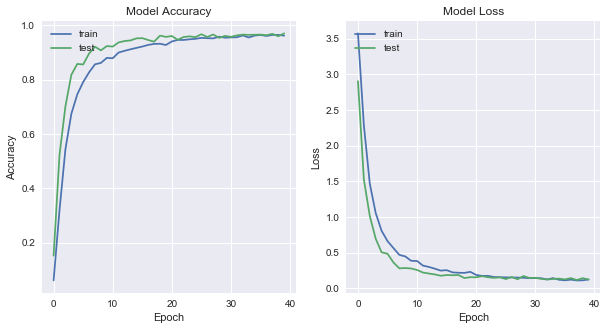

In [32]:
# accuracy vs. epoch and loss vs. epoch graphs
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.plot(history9.history['acc']), plt.plot(history9.history['val_acc'])
plt.title('Model Accuracy'), plt.ylabel('Accuracy'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.subplot(1, 2, 2)
plt.plot(history9.history['loss']), plt.plot(history9.history['val_loss'])
plt.title('Model Loss'), plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

### Final CNN model

CNN classification report: 

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.96      0.98       122
           2       0.97      0.94      0.95       124
           3       0.96      0.96      0.96        78
           4       0.94      0.98      0.96       109
           5       0.94      0.91      0.93       102
           6       1.00      1.00      1.00        23
           7       0.96      0.96      0.96        79
           8       0.95      0.99      0.97        78
           9       1.00      0.96      0.98        81
          10       0.99      0.96      0.98       111
          11       1.00      0.93      0.96        73
          12       0.97      1.00      0.99       115
          13       1.00      1.00      1.00       119
          14       1.00      1.00      1.00        43
          15       1.00      1.00      1.00        35
          16       0.88      1.00      0.94        

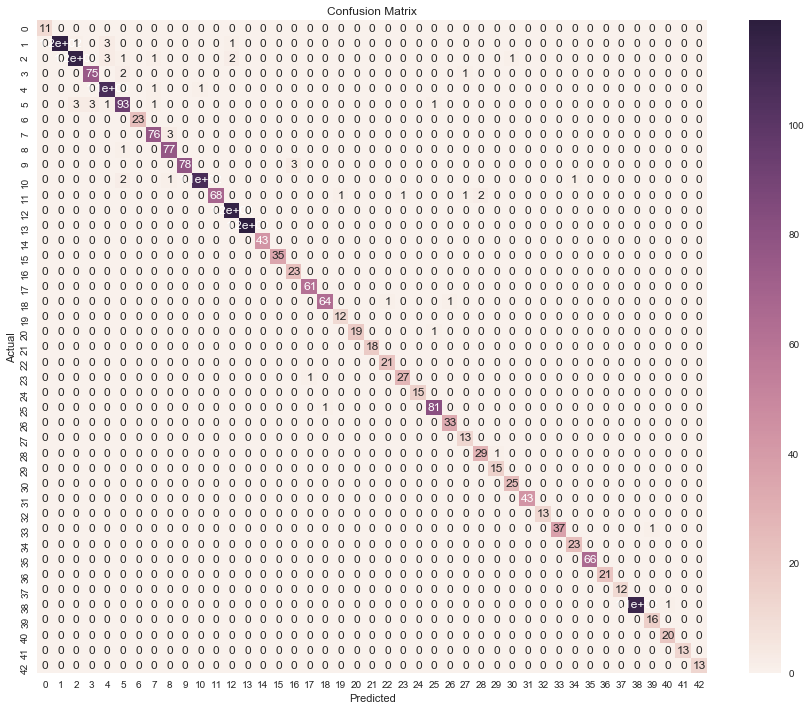

In [41]:
# classification report
y_prob = model7.predict(x_val)
cls_pred = y_prob.argmax(axis = -1)
print("CNN classification report:", "\n\n", classification_report(y_val, cls_pred))
precision, recall, fbeta_score, support = precision_recall_fscore_support(y_val, cls_pred, average = 'weighted')

# accuracy confusion matrix
cm = confusion_matrix(y_val, cls_pred)
plt.figure(figsize = (15, 12))
sns.heatmap(cm, annot = True)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.grid(False)
plt.show()

In [42]:
print('The validation precision score is', precision, '\nThe validation recall score is', recall,\
      '\nThe validation f-score is', fbeta_score)

The validation precision score is 0.9769548192855958 
The validation recall score is 0.9763560500695411 
The validation f-score is 0.9763673882804611


### Final 3 Models

| Classifiers | Precision | Recall | F-Score |
| --- | --- | --- | --- |
| CNN with the Architecture of Conv-Pool-Conv-Pool-Dropout (model7) | 0.976955 | 0.976356 | 0.976367 |
| Thresheld + Feature Selected (Wrapper-based) Random Forest Classifier from Part II | 0.924908 | 0.918869 | 0.918973 |
| Thresheld + Feature Selected (Wrapper-based) Support Vector Machine Classifier from Part II | 0.923204 | 0.919796 | 0.920249 |
